In [64]:
from binance.client import Client
import pandas as pd
import numpy as np
from itertools import product

np.set_printoptions(suppress=True)

In [2]:
api_key = "8AiGAyxlhYQaRpE1s7097hx5sZ12Ogtr8ir9DsyztaD5j24LrI0fEoToDzCI5lle"
api_secret = "VhudTs0HsBVFNdSTghmqfCjUuIXF6rFiXIfROxHIaM71TGgib7NeZ5aOsJUHjI9f"

In [3]:
client = Client(api_key=api_key, api_secret=api_secret)

In [4]:
def get_history(symbol, interval, start, end=None):
    bars = client.get_historical_klines(symbol=symbol, interval=interval, start_str=start, end_str=end, limit=1000)
    
    df = pd.DataFrame(bars)
    df["Date"] = pd.to_datetime(df.iloc[:,0], unit="ms")
    df.columns = ["Open Time", "Open", "High", "Low", "Close", "Volume", "Close Time", "Quote Asset Volume", "Number Of Trades", "Taker Buy Base Asset Volume", "Taker Buy Quote Asset Volume", "Ignore", "Date"]
    df = df[["Date", "Open", "High", "Low", "Close", "Volume"]].copy()
    df.set_index("Date", inplace=True)

    for column in df.columns:
        df[column] = pd.to_numeric(df[column], errors="coerce")
    return df

In [9]:
df = get_history("BTCUSDT", "1h", "1-1-2000")

In [10]:
df

,Open,High,Low,Close,Volume
Date,,,,,
2017-08-17 04:00:00,4261.48,4313.62,4261.32,4308.83,47.181009
2017-08-17 05:00:00,4308.83,4328.69,4291.37,4315.32,23.234916
2017-08-17 06:00:00,4330.29,4345.45,4309.37,4324.35,7.229691
2017-08-17 07:00:00,4316.62,4349.99,4287.41,4349.99,4.443249
2017-08-17 08:00:00,4333.32,4377.85,4333.32,4360.69,0.972807
...,...,...,...,...,...
2022-11-01 04:00:00,20482.57,20521.87,20466.71,20495.53,8905.815880
2022-11-01 05:00:00,20495.99,20555.21,20491.85,20530.41,8071.529080
2022-11-01 06:00:00,20530.41,20662.80,20525.21,20624.57,14020.497730


In [69]:
class strategy_tester():
    def __init__(self, units=1, tc=0.1):
        self.units = units
        self.tc = tc
        self.data = None

    def get_data(self):
        self.data = pd.read_csv(self.filepath, parse_dates=["date"], index_col="date").iloc[::-1]
        
    def get_history(self, symbol, interval, start="1-1-2000", end=None):
        bars = client.get_historical_klines(symbol=symbol, interval=interval, start_str=start, end_str=end, limit=1000)
        
        df = pd.DataFrame(bars)
        df["Date"] = pd.to_datetime(df.iloc[:,0], unit="ms")
        df.columns = ["Open Time", "Open", "High", "Low", "Close", "Volume", "Close Time", "Quote Asset Volume", "Number Of Trades", "Taker Buy Base Asset Volume", "Taker Buy Quote Asset Volume", "Ignore", "Date"]
        df = df[["Date", "Open", "High", "Low", "Close", "Volume"]].copy()
        df.set_index("Date", inplace=True)

        for column in df.columns:
            df[column] = pd.to_numeric(df[column], errors="coerce")
        self.data = df    
    
    def prepare_data(self, sma1, sma2):
        df = self.data[["Close", "Volume"]].copy()
        df["returns"] = np.log(df.Close.div(df.Close.shift(1)))
        df["sma1"] = df.Close.rolling(sma1).mean()
        df["sma2"] = df.Close.rolling(sma2).mean()
        condition = df.sma1 > df.sma2
        df["position"] = 0
        df.loc[condition, "position"] = 1
    
        self.data = df
    
    def run_backtest(self):
        df = self.data.copy()
        df["strategy"] = df.returns * df.position.shift(1)
        df["trades"] = df.position.diff().fillna(0).abs()  # To calculate fees and shit
#         df.strategy = df.strategy + (df.trades * self.tc)  # Calculate fees and shit
        df["creturns"] = df.returns.cumsum().apply(np.exp)
        df["cstrategy"] = df.strategy.cumsum().apply(np.exp)
        self.data = df.copy()
        
    def test_strategy(self, sma1, sma2):
        if self.data is None:
            self.get_history("BTCUSDT", "1h")
        df = self.data.copy()
        self.prepare_data(sma1, sma2)
        self.run_backtest()
        
    def optimize_strategy(self, sma1r, sma2r):
        self.datas = []
        performance = []
        self.get_history("BTCUSDT", "1h", start="1-1-2021")
        print("Patched data")
        combinations = list(product(sma1r, sma2r))
        for comb in combinations:
            self.test_strategy(comb[0], comb[1])
#             self.datas.append(self.data)
            performance.append(self.calc_creturn(self.data))
        self.results_overview =  pd.DataFrame(data=np.array(combinations), columns=["sma1", "sma2"])
        self.results_overview["cstrategy"] = performance
        
    def calc_creturn(self, series):
        return float(series[["strategy"]].sum().apply(np.exp))

In [49]:
trader = strategy_tester()

In [60]:
trader.test_strategy(7, 20)

In [61]:
trader.data

,Close,Volume,returns,sma1,sma2,position,strategy,trades,creturns,cstrategy
Date,,,,,,,,,,
2017-08-17 04:00:00,4308.83,47.181009,NaN,NaN,NaN,0,NaN,0.0,NaN,NaN
2017-08-17 05:00:00,4315.32,23.234916,0.001505,NaN,NaN,0,0.0,0.0,1.001506,1.00000
2017-08-17 06:00:00,4324.35,7.229691,0.002090,NaN,NaN,0,0.0,0.0,1.003602,1.00000
2017-08-17 07:00:00,4349.99,4.443249,0.005912,NaN,NaN,0,0.0,0.0,1.009552,1.00000
2017-08-17 08:00:00,4360.69,0.972807,0.002457,NaN,NaN,0,0.0,0.0,1.012036,1.00000
...,...,...,...,...,...,...,...,...,...,...
2022-11-03 15:00:00,20248.62,19408.450260,-0.003450,20214.737143,20242.0625,0,-0.0,0.0,4.699331,14.98379
2022-11-03 16:00:00,20295.37,15077.113540,0.002306,20211.370000,20248.0510,0,0.0,0.0,4.710181,14.98379
2022-11-03 17:00:00,20226.18,11386.268960,-0.003415,20205.445714,20251.7585,0,-0.0,0.0,4.694123,14.98379


In [36]:
trader.data[["strategy"]].sum().apply(np.exp)

strategy    12.305604
dtype: float64

<AxesSubplot: xlabel='Date'>

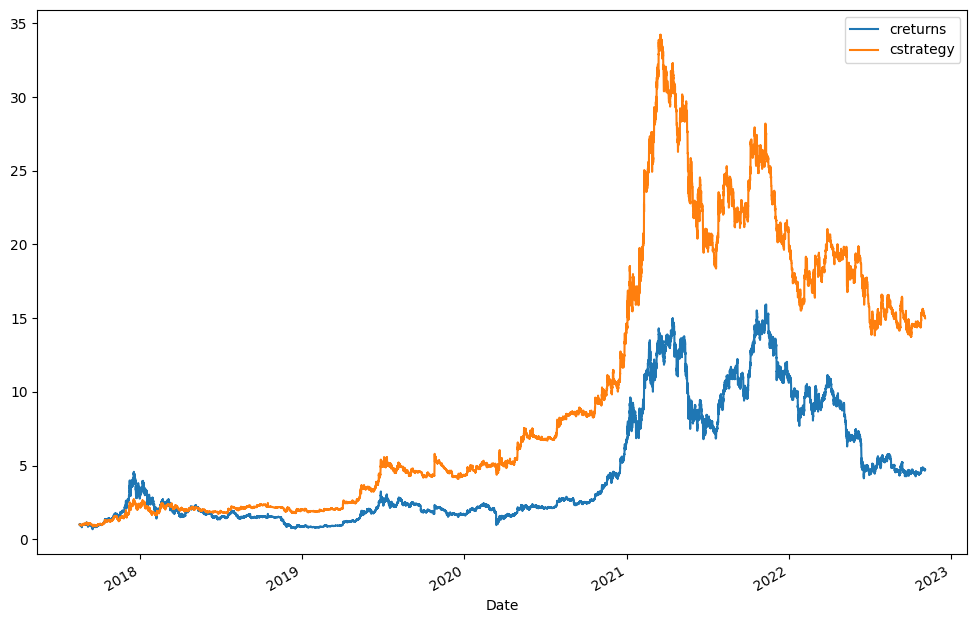

In [62]:
trader.data[["creturns", "cstrategy"]].plot(figsize=(12, 8))

In [25]:
trader.data.nsmallest(10, "strategy")

,Close,Volume,returns,sma1,sma2,position,strategy,trades,creturns,cstrategy
Date,,,,,,,,,,
2020-03-15 22:00:00,5367.76,22974.081197,-0.095180,5367.914444,5327.0610,1,-0.095180,0.0,1.245758,1.029563e+55
2018-01-11 03:00:00,12920.00,3381.173271,-0.090042,14311.606667,14137.2595,1,-0.090042,0.0,2.998494,4.110173e+08
2019-06-26 20:00:00,12872.77,16357.667512,-0.081136,13277.976667,12831.1410,1,-0.081136,0.0,2.987533,5.751456e+38
2017-11-29 19:00:00,9306.00,1606.860034,-0.078307,10568.098889,10428.4465,1,-0.078307,0.0,2.159751,9.911488e+05
2018-10-15 07:00:00,6860.25,14635.970299,-0.077091,6574.914444,6466.6435,1,-0.077091,0.0,1.592138,4.959877e+23
2017-09-16 10:00:00,3480.00,175.251826,-0.075545,3771.968889,3733.4240,1,-0.075545,0.0,0.807644,3.903196e+01
2021-01-02 20:00:00,30667.22,15733.283112,-0.074137,31906.740000,30624.3980,1,-0.074137,0.0,7.117296,1.208134e+73
2017-12-23 23:00:00,13300.00,1147.320236,-0.072856,14363.770000,14186.1005,1,-0.072856,0.0,3.086685,2.896658e+07
2020-08-02 04:00:00,11169.84,21611.397748,-0.071689,11777.006667,11710.4955,1,-0.071689,0.0,2.592314,1.153943e+63


In [70]:
trader.optimize_strategy(range(5, 12), range(15, 24))

Patched data


In [71]:
trader.results_overview.nlargest(18, "cstrategy")

,sma1,sma2,cstrategy
62,11,23,27.545590
44,9,23,27.209176
61,11,22,24.067817
35,8,23,21.632664
34,8,22,19.213887
25,7,22,19.094582
7,5,22,18.652612
53,10,23,18.445090
6,5,21,18.278301
33,8,21,17.228641
